### 데이터 셋 선정
 - imdb 데이터 세트
 - 인터넷 영화 데이터베이스에서 가져온 5만개의 영화 리뷰 텍스트 포함 
    - 훈련용 테스트용 5:5 비율로 나뉨

In [26]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses

+ get_file : 파일 다운로드, untar (압축 해제)
+ os.path.join : 두 번째 인수 명의 디렉토리에 파일 저장

In [27]:
'''
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
'''
dataset_dir = './aclImdb'

<p style="font-weight:bold">트레인 디렉토리</p>

In [28]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

<p style="font-weight:bold;">파일 예시</p>

In [29]:
sample_data = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_data) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


- 추가 폴더 제거

In [30]:
'''
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
'''

"\nremove_dir = os.path.join(train_dir, 'unsup')\nshutil.rmtree(remove_dir)\n"

# 데이터 전처리

##### 데이터 셋 분할
 - 8 : 2로 분할
 - 테스트 셋은 이미지 존재하기에 트레인 셋에서 분리하여 검증 셋을 생성 

In [31]:
batch_size = 32
seed = 42

train_data = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                       batch_size=batch_size,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=seed)

valid_data = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                       batch_size=batch_size,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=seed)
test_data = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                      batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


- 구두 점 등의 특수 문자와 대문자가 혼합되어 있는 것을 확인 -> 텍스트 정제 

In [32]:
for text_batch, label_batch in train_data.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

print(train_data.take(1))

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

##### 텍스트 데이터 표준화 -> 텍스트 데이터 전처리

In [33]:
# 소문자 변환, html 태그 제거, 구두점 제거
def standardization(data):
    lower_data = tf.strings.lower(data)
    stripped_html = tf.strings.regex_replace(lower_data, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

##### TextVectorization 레이어 생성
 - 각 토큰에 고유한 정수 인덱스 생성 output_mode => int
 - 텍스트 특징을 정수 시퀀스에 매핑하는 전처리 계층

In [34]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens = max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

train_txt = train_data.map(lambda x, y: x)
vectorize_layer.adapt(train_txt)

def vectorize_txt(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

print(train_txt)

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>


In [35]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_data))

def check_data(text_batch, label_batch, idx):
    ex_review, ex_label = text_batch[idx], label_batch[idx]
    print("Review", ex_review)
    print("Label", train_data.class_names[ex_label])
    print("Vectorized review", vectorize_txt(ex_review, ex_label))

check_data(text_batch, label_batch, 10)

Review tf.Tensor(b"While the overall idea of Escape from Atlantis was intriguing, I found the film to be far less than what I had hoped for upon reading the plot summery. Perhaps I am too much of a child in the technological age: the movie was made, as it is now 2002, an official five years ago --after viewing fantasy epics such as Lord of the Rings, and science fiction feats like Star Wars, as a whole it could not compare to other movies of similar line such as Dinotopia or Homer's The Odyssey.<br /><br />My beef, basically, is that I couldn't relate --I am just about the same age of the children (a young adult), and have no trouble putting myself in the place of a middle-aged man if that is the character available. But the picture did not take me to a different mental plain of existence. I didn't find myself saying 'ACK! I would have done the SAME thing!'. It did not open the doors to my imagination. Even without comparing it to high-budget films or other TV movies, standing alone, c

> .cache() : 변환된 데이터셋을 메모리 또는 로컬 저장소에 캐시 가능  
> .prefetch() : 데이터가 생성되는 시간과 데이터가 소비되는 시간 분리, 내부 버퍼를 사용하여 요청된 시간보다 앞서
입력 데이터세트에서 요소를 미리 가져옴 (AUTOTUNE : 런타임에 값을 동적으로 조정)

### 훈련 시킬 데이터 셋 설정

In [36]:
train_set = train_data.map(vectorize_txt)
valid_set = valid_data.map(vectorize_txt)
test_set = test_data.map(vectorize_txt)

# 입출력 차단 방치 
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)


### 기본 모델 구현

In [37]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Dropout, Embedding

'''
model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dims),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
'''

sequence_len = 250

def embedding_model(max_feature, embedding_dim):
    model = Sequential()
    model.add(Embedding(max_feature+1, embedding_dim))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

base_model = embedding_model(max_features, sequence_len)

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding_2 (Embedding)     (None, None, 250)         2500250   
                                                                 
 dropout_3 (Dropout)         (None, None, 250)         0         
                                                                 
 global_average_pooling1d_1   (None, 250)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                                 
Total params: 2,500,501
Trainable params: 2,500,501
Non-trainable params: 0
_________________________________________________________________


### 기본 모델 훈련

In [38]:
base_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                   optimizer='adam',
                   metrics=['accuracy'])

In [39]:
'''epochs=50

record_base = base_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=epochs
)'''

'epochs=50\n\nrecord_base = base_model.fit(\n    train_set,\n    validation_data=valid_set,\n    epochs=epochs\n)'

In [40]:
def draw_graph(history, name):
    fig, ax1 = plt.subplots()

    plt.title(name + ' acc evaluate')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('accuracy')
    ax1.plot(history.history['accuracy'], color='blue')
    ax1.plot(history.history['val_accuracy'],color='red')
    ax1.tick_params(axis='y',)
    ax1.legend(['acc', 'val_acc'], loc='upper left')

    ax2 = ax1.twinx()  # x축을 공유하는 두 번째 축을 생성합니다.

    ax2.set_ylabel('loss')
    ax2.plot(history.history['loss'], color='blue', linestyle='dashed')
    ax2.plot(history.history['val_loss'], color='red', linestyle='dashed')
    ax2.tick_params(axis='y')
    ax2.legend(['loss', 'val_loss'], loc='upper right')

    fig.tight_layout()  # 그래프가 겹치지 않도록 레이아웃을 조정합니다.
    plt.show()


In [41]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Dropout, LSTM 

class medical_LSTM(tf.keras.Model):
    def __init__(self,max_feature, embedding_dim, lstm_units, dense_output_dim, dropout_rate, l2_reg_rate):
        super(medical_LSTM, self).__init__()

        self.embedding = Embedding(max_feature+1, embedding_dim)

        self.first_lstm = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, return_sequences=True))

        self.dropout = Dropout(dropout_rate)
        
        self.batch_normalization = BatchNormalization()

        self.last_lstm = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, return_sequences=False))

        self.last_dense = Dense(dense_output_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l2_reg_rate))
    
    def call(self, inputs):

        inputs = tf.cast(inputs, dtype=tf.float32)

        embedding_ouput = self.embedding(inputs)

        first_lstm_output = self.first_lstm(embedding_ouput)

        dropout_output = self.dropout(first_lstm_output)

        normalized_output = self.batch_normalization(dropout_output)

        last_lstm_output = self.last_lstm(normalized_output)

        last_dense_outputs = self.last_dense(last_lstm_output)

        return last_dense_outputs      

In [42]:
from tensorflow.keras.optimizers import Adam

lstm_units = 96
final_output_dim = 1
dropout_rate = 0.4
optimizer = Adam(learning_rate=0.004)
embedding_dims = 32

sequence_len = 250
features = 10000

model = medical_LSTM(
            max_feature=max_features,
            embedding_dim = embedding_dims,
            lstm_units = lstm_units, 
            dense_output_dim = final_output_dim,
            dropout_rate= dropout_rate,
            l2_reg_rate=0.0041)

model.compile(optimizer = optimizer, loss=losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.build(input_shape=[max_features, sequence_len])
model.summary()

Model: "medical_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  320032    
                                                                 
 bidirectional_2 (Bidirectio  multiple                 99072     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 batch_normalization_1 (Batc  multiple                 768       
 hNormalization)                                                 
                                                                 
 bidirectional_3 (Bidirectio  multiple                 221952    
 nal)                                                            
                                                    

In [43]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import Hyperband

def build_model(hp):
    model = medical_LSTM(
        max_feature= hp.Int('max_features', min_value=1000, max_value= max_features, step=1000),
        embedding_dim= hp.Int('embedding_dims', min_value=16, max_value=32, step=16),
        lstm_units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        dense_input_dim=hp.Int('dense_input_dim', min_value=32, max_value=256, step=32),
        dense_output_dim=1,
        dropout_rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.01),
        l2_reg_rate=hp.Float('l2_reg_rate', min_value=0.001, max_value=0.01, step=0.001)
    )
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

'''tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    directory='hyperband',
    project_name='medical_LSTM'
)

tuner.search(train_set, epochs=10, validation_data=valid_set)
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"lstm 유닛 수 : {best_hp.get('lstm_units')}")
print(f"dropout_rate : {best_hp.get('dropout_rate')}")
print(f"l2_reg_rate : {best_hp.get('l2_reg_rate')}")
print(best_hp.get('max_features'))
print(best_hp.get('embedding_dims'))'''

'tuner = Hyperband(\n    build_model,\n    objective=\'val_accuracy\',\n    max_epochs=5,\n    directory=\'hyperband\',\n    project_name=\'medical_LSTM\'\n)\n\ntuner.search(train_set, epochs=10, validation_data=valid_set)\nbest_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]\n\nprint(f"lstm 유닛 수 : {best_hp.get(\'lstm_units\')}")\nprint(f"dropout_rate : {best_hp.get(\'dropout_rate\')}")\nprint(f"l2_reg_rate : {best_hp.get(\'l2_reg_rate\')}")\nprint(best_hp.get(\'max_features\'))\nprint(best_hp.get(\'embedding_dims\'))'

In [44]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

my_record = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


c:\Users\Administrator\AppData\Roaming\Python\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


625/625 [==============================] - 28s 40ms/step - loss: 0.6152 - accuracy: 0.6511 - val_loss: 0.6762 - val_accuracy: 0.6332
Epoch 2/50
625/625 [==============================] - 24s 38ms/step - loss: 0.3868 - accuracy: 0.8357 - val_loss: 0.4276 - val_accuracy: 0.8148
Epoch 3/50
625/625 [==============================] - 24s 38ms/step - loss: 0.3234 - accuracy: 0.8653 - val_loss: 0.4184 - val_accuracy: 0.8262
Epoch 4/50
625/625 [==============================] - 25s 40ms/step - loss: 0.2871 - accuracy: 0.8833 - val_loss: 0.3981 - val_accuracy: 0.8408
Epoch 5/50
625/625 [==============================] - 38s 61ms/step - loss: 0.2618 - accuracy: 0.8975 - val_loss: 0.6343 - val_accuracy: 0.7164
Epoch 6/50
625/625 [==============================] - 37s 59ms/step - loss: 0.2335 - accuracy: 0.9136 - val_loss: 0.3794 - val_accuracy: 0.8534
Epoch 7/50
625/625 [==============================] - 24s 39ms/step - loss: 0.2021 - accuracy: 0.9255 - val_loss: 0.3761 - val_accuracy: 0.8564
Epo

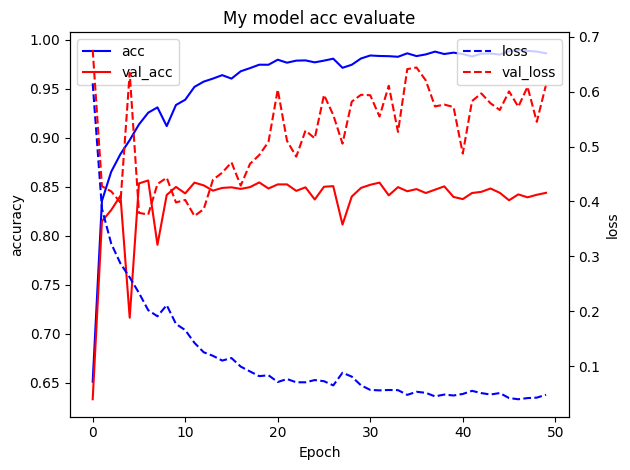

In [48]:
draw_graph(my_record, 'My model')